In [1]:
from __future__ import annotations
"""
Collect aggregate stats CKA etc... from everything.

TODO(Adriano) 1st do without the controls, THEN do with the controls.
"""
from pathlib import Path

embeddings_paths = [Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings")]
paths_ols_linear = [Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/ols_all_datasets")]
paths_gd_mlp = [
    # NOTE: we will only include the layers for the larger numbers of layer
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers_2plus_v1")
]

In [2]:
16 * 17 * 7 * 6

11424

In [2]:
"""
Shit here is copied from `pokemon.py` and `quadrocopter_evolved.ipynb`.
"""

from typing import List
################ GET MODEL FILES ################
# TODO: not clear what is going on here exactly
# def __get_model_files(model_dir: Path) -> List[Path]:
#     return  [
#             # embeddings
#             model_dir / f"embeddings_corpus_train.safetensors",
#             model_dir / f"embeddings_corpus_validation.safetensors",
#             model_dir / f"embeddings_queries_train.safetensors",
#             model_dir / f"embeddings_queries_validation.safetensors",
#             # metadata
#             model_dir / f"metadatas_corpus_train.jsonl",
#             model_dir / f"metadatas_corpus_validation.jsonl",
#             model_dir / f"metadatas_queries_train.jsonl",
#             model_dir / f"metadatas_queries_validation.jsonl",
#         ]
# def __get_reversed_model_files(model_dir: Path) -> List[Path]:
#     return [
#         # reverse because sometimes we do "corpus_embeddings..."
#         #
#         # saftensors
#         model_dir / f"corpus_train_embeddings.safetensors",
#         model_dir / f"queries_train_embeddings.safetensors",
#         model_dir / f"corpus_validation_embeddings.safetensors",
#         model_dir / f"queries_validation_embeddings.safetensors",
#         # jsonls
#         model_dir / f"corpus_train_metadatas.jsonl",
#         model_dir / f"queries_train_metadatas.jsonl",
#         model_dir / f"corpus_validation_metadatas.jsonl",
#         model_dir / f"queries_validation_metadatas.jsonl",
#     ]

# def get_model_files(model_dir: Path) -> List[Path]:
#     files = __get_model_files(model_dir)
#     if not all(f.exists() for f in files):
#         files = __get_reversed_model_files(model_dir)
#     assert all(f.exists() for f in files), f"Files {files} do not exist in {model_dir}"
#     return files

################ GET EMBEDDINGS PATHS ################
def get_embeddings_paths(embeddings_path: Path):
    record_type = "corpus"
    embeddings_train_path = embeddings_path / f"embeddings_{record_type}_train.safetensors"
    embeddings_validation_path = embeddings_path / f"embeddings_{record_type}_validation.safetensors"
    assert (
        (embeddings_train_path.exists() and embeddings_validation_path.exists()) or 
        (not embeddings_train_path.exists() and not embeddings_validation_path.exists())
    )
    if not embeddings_train_path.exists():
        # NOTE: that sometimes the path names are reversed, i.e. when using OpenAI models; you can observe
        # more in detail in `get_reversed_model_files` in `sanity_check_embeddings_note_equal.ipynb`
        embeddings_train_path = embeddings_path / f"{record_type}_train_embeddings.safetensors"
        embeddings_validation_path = embeddings_path / f"{record_type}_validation_embeddings.safetensors"
    assert embeddings_train_path.exists() and embeddings_validation_path.exists(), f"Files {embeddings_train_path} and {embeddings_validation_path} do not exist" # fmt: skip
    return embeddings_train_path, embeddings_validation_path

def get_all_embeddings(embeddings_path: Path, dataset: str, device: str) -> Dict[str, torch.Tensor]:
    model2embeddings: Dict[str, torch.Tensor] = {}
    for model_name in MODEL_NAMES:
        embeddings_path_src_parent  = embeddings_path / model_name.replace("/", "_") / dataset
        embeddings_path_src_train, _ = get_embeddings_paths(embeddings_path_src_parent)
        embeddings_src_train = load_file(embeddings_path_src_train)["embeddings"].to(device)
        model2embeddings[model_name] = embeddings_src_train
    return model2embeddings

################ models and constants ################
from __future__ import annotations
import click
import random
import math
import gc
import torch
import einops
import numpy as np
import time
import wandb
import torch.nn as nn
from typing import List, Optional, Dict, Literal, Tuple
from pathlib import Path
from pydantic import BaseModel
from safetensors.torch import load_file, save_file
from torch.utils.data import Dataset, DataLoader
import tqdm

DATASETS = [
    # (numbers are counts for documents, there may be some longer documents -> slightly more chunks)
    "arguana", # 10K
    "fiqa", # 50K -> 20K
    "scidocs", # 25K -> 20K
    "nfcorpus", # 5K
    "hotpotqa", # 100K -> 20K
    "trec-covid", # too much -> 20K
]

MODEL_NAMES = [
    "WhereIsAI/UAE-Large-V1",
    "BAAI/bge-base-en-v1.5",
    "BAAI/bge-large-en-v1.5",
    "BAAI/bge-small-en-v1.5",
    "intfloat/e5-base-v2",
    "intfloat/e5-large-v2",
    "intfloat/e5-small-v2",
    "thenlper/gte-base",
    "thenlper/gte-large",
    "thenlper/gte-small",
    "sentence-transformers/gtr-t5-base",
    "sentence-transformers/gtr-t5-large",
    "mixedbread-ai/mxbai-embed-large-v1",
    "sentence-transformers/sentence-t5-base",
    "sentence-transformers/sentence-t5-large",
    "openai/text-embedding-3-large",
    "openai/text-embedding-3-small",
]
N_LAYERS = list(range(0, 8)) # 0 -> OLS

class StitchPair(BaseModel):
    source: str
    target: str
    dataset: str
    num_layers: Optional[int] = None
    # NOTE: first layer size SHOULD be input dim and last layer SHOULD size be output dim
    layer_dims: Optional[List[int]] = None
    mode: Literal["affine", "mlp", "affine_ols"] = "mlp"

class MLP(nn.Module):
    def __init__(
        self, 
        input_dim: int,
        output_dim: int,
        source_model_name: str,
        target_model_name: str,
        dataset: str,
        hidden_dims: Optional[List[int]] = None,
        num_layers: int = 1
    ):
        super().__init__()
        num_layers = num_layers or len(hidden_dims)
        if num_layers is None:
            raise ValueError("Either num_layers or hidden_dims must be provided")
        if hidden_dims is None:
            hidden_dims = [max(input_dim, output_dim)] * (num_layers - 1)
            
        # Build layer dimensions including input and output
        layer_dims = [input_dim] + hidden_dims + [output_dim]
        
        # Create sequential model with linear layers and ReLU activations
        layers: List[nn.Module] = []
        for i in range(len(layer_dims)-1):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
            if i < len(layer_dims)-2:  # No ReLU after final layer
                layers.append(nn.ReLU())
                
        self.model = nn.Sequential(*layers)
        self.source_model_name = source_model_name
        self.target_model_name = target_model_name
        self.dataset = dataset
        self.num_layers = num_layers
        self.layer_dims = layer_dims
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
    
    def save_to_folder_path(self, save_path: Path):
        assert not save_path.is_file(), f"Save path {save_path} is a file, not a directory"
        save_path.mkdir(parents=True, exist_ok=True)
        model_file = save_path / f"mlp.safetensors"
        info_file = save_path / f"stitch_info.json"
        assert not model_file.exists(), f"Model file already exists at {model_file}"
        assert not info_file.exists(), f"Info file already exists at {info_file}"
        save_file(self.state_dict(), model_file)
        info_file.write_text(
            StitchPair(
                source=self.source_model_name,
                target=self.target_model_name,
                dataset=self.dataset,
                mode="mlp",
                num_layers=self.num_layers,
                layer_dims=self.layer_dims
            ).model_dump_json()
        )
    
    @staticmethod
    def load_from_folder_path(load_path: Path):
        assert load_path.is_dir(), f"Load path {load_path} is not a directory"
        model_file = load_path / f"mlp.safetensors"
        info_file = load_path / f"stitch_info.json"
        assert model_file.exists(), f"Model file does not exist at {model_file}"
        assert info_file.exists(), f"Info file does not exist at {info_file}"
        pd_model = StitchPair.model_validate_json(info_file.read_text())
        hidden_dims = pd_model.layer_dims[1:-1]
        return MLP(
            input_dim=pd_model.layer_dims[0],
            output_dim=pd_model.layer_dims[-1],
            source_model_name=pd_model.source,
            target_model_name=pd_model.target,
            dataset=pd_model.dataset,
            hidden_dims=hidden_dims,
            num_layers=pd_model.num_layers,
        )
    
    def __repr__(self):
        return f"MLP(input_dim={self.input_dim}, output_dim={self.output_dim}, hidden_dims={self.hidden_dims}, num_layers={self.num_layers})"


def model2model_dimension(model_name: str) -> int:
    """ Helper: get the size of the embedding dimension vector (1D, usually something like 768-4096). """
    # Miscellaneous (HF)
    if "/" in model_name:
        assert model_name.count("/") == 1
        model_name = model_name.split("/")[-1]
    if model_name == "SFR-Embedding-Mistral":
        return 4096
    elif model_name == "UAE-Large-V1":
        return 1024
    elif model_name == "mxbai-embed-large-v1":
        return 1024
    # BGE Models (HF)
    elif model_name == "bge-base-en-v1.5":
        return 768
    elif model_name == "bge-large-en-v1.5":
        return 1024
    elif model_name == "bge-small-en-v1.5":
        return 384
    #  E5 Models (HF)
    elif model_name == "e5-base-v2":
        return 768
    elif model_name == "e5-large-v2":
        return 1024
    elif model_name == "e5-small-v2":
        return 384
    # GTE Models (HF)
    elif model_name == "gte-base":
        return 768
    elif model_name == "gte-large":
        return 1024
    elif model_name == "gte-small":
        return 384
    # GTR-T5 Models (HF)
    elif model_name == "gtr-t5-base":
        return 768
    elif model_name == "gtr-t5-large":
        return 768
    # Sentence T5 (HF)
    elif model_name == "sentence-t5-base":
        return 768
    elif model_name == "sentence-t5-large":
        return 768
    # OpenAI Models
    elif model_name == "text-embedding-3-large":
        return 3072
    elif model_name == "text-embedding-3-small":
        return 1536
    else:
        # NOTE: cohere may be supported in THE FUTURE
        raise ValueError(f"Unsupported model: {model_name}")

In [3]:
"""
First, be able to get all the models.
"""

def get_all_model(stitch_info_parent_path: Path) -> MLP:
    stitch_info_file = stitch_info_parent_path / "stitch_info.json"
    if not stitch_info_file.exists():
        stitch_info_file = stitch_info_parent_path / "stitch_info_pairs.json"
    assert stitch_info_file.exists(), f"Stitch info file does not exist at {stitch_info_file}"
    stitch_info = StitchPair.model_validate_json(stitch_info_file.read_text())
    if stitch_info.mode == "mlp":
        return MLP.load_from_folder_path(stitch_info_parent_path)
    else:
        assert stitch_info.mode in ["affine_ols", "affine", "mlp"], f"Unsupported mode: {stitch_info.mode}"
        src_dim: int = model2model_dimension(stitch_info.source)
        dst_dim: int = model2model_dimension(stitch_info.target)
        mlp = MLP(
            input_dim=src_dim,
            output_dim=dst_dim,
            source_model_name=stitch_info.source,
            target_model_name=stitch_info.target,
            dataset=stitch_info.dataset,
            hidden_dims=[],
            num_layers=0 if stitch_info.mode == "affine_ols" else 1 if stitch_info.mode == "affine" else stitch_info.num_layers
        )
        assert stitch_info.mode != "mlp" or stitch_info.num_layers is not None
        state_dict_file = (
            stitch_info_parent_path / "linear_transform.safetensors" if stitch_info.mode == "affine_ols" else 
            stitch_info_parent_path / "checkpoints" / "checkpoint_40.safetensors"
        )
        assert state_dict_file.exists(), f"State dict file does not exist at {state_dict_file}"
        state_dict = load_file(state_dict_file)
        assert len(mlp.model) == 1
        weights = state_dict["weights"] if "weights" in state_dict else state_dict["weight"]
        biases = state_dict["biases"] if "biases" in state_dict else state_dict["bias"]
        mlp.model[0].weight.data = weights
        mlp.model[0].bias.data = biases
        return mlp

GET_OLS = False
ols_paths: List[Path] = []
for path in tqdm.tqdm(paths_ols_linear):
    relevant_paths_ = list(set(x.parent for x in list(path.glob("**/stitch_info.json")) + list(path.glob("**/stitch_info_pairs.json"))))
    ols_paths.extend(relevant_paths_)
    ols_paths = list(set(ols_paths))
if GET_OLS:
# print('\n'.join(x.as_posix() for x in ols_paths))
    ols_mlps = [get_all_model(path) for path in tqdm.tqdm(ols_paths)] # OLS MLPs
GET_NNS = False
nn_paths = []
for path in tqdm.tqdm(paths_gd_mlp):
    # print("Considering subpaths of ", path)
    relevant_paths_ = list(set(x.parent for x in list(path.glob("**/stitch_info.json")) + list(path.glob("**/stitch_info_pairs.json"))))
    nn_paths.extend(relevant_paths_)
    nn_paths = list(set(nn_paths))
if GET_NNS:
    # print('\n'.join(x.as_posix() for x in nn_paths))
    nn_mlps = [get_all_model(path) for path in tqdm.tqdm(nn_paths)] # NN MLPs

100%|██████████| 1/1 [00:38<00:00, 38.46s/it]


In [32]:
for dataset in DATASETS:
    for src_model_name in MODEL_NAMES:
        for dst_model_name in MODEL_NAMES:
            for layer_n in N_LAYERS:
                if not any([
                    nn_mlp.source_model_name == src_model_name and nn_mlp.target_model_name == dst_model_name and nn_mlp.num_layers == layer_n
                    for nn_mlp in nn_mlps + ols_mlps
                ]):
                    print(f"No MLP found for {src_model_name} -> {dst_model_name} at layer {layer_n}")


No MLP found for WhereIsAI/UAE-Large-V1 -> WhereIsAI/UAE-Large-V1 at layer 0
No MLP found for WhereIsAI/UAE-Large-V1 -> WhereIsAI/UAE-Large-V1 at layer 1
No MLP found for WhereIsAI/UAE-Large-V1 -> WhereIsAI/UAE-Large-V1 at layer 2
No MLP found for WhereIsAI/UAE-Large-V1 -> WhereIsAI/UAE-Large-V1 at layer 3
No MLP found for WhereIsAI/UAE-Large-V1 -> WhereIsAI/UAE-Large-V1 at layer 4
No MLP found for WhereIsAI/UAE-Large-V1 -> WhereIsAI/UAE-Large-V1 at layer 5
No MLP found for WhereIsAI/UAE-Large-V1 -> WhereIsAI/UAE-Large-V1 at layer 6
No MLP found for WhereIsAI/UAE-Large-V1 -> WhereIsAI/UAE-Large-V1 at layer 7
No MLP found for WhereIsAI/UAE-Large-V1 -> BAAI/bge-base-en-v1.5 at layer 2
No MLP found for WhereIsAI/UAE-Large-V1 -> BAAI/bge-base-en-v1.5 at layer 3
No MLP found for WhereIsAI/UAE-Large-V1 -> BAAI/bge-base-en-v1.5 at layer 4
No MLP found for WhereIsAI/UAE-Large-V1 -> BAAI/bge-base-en-v1.5 at layer 5
No MLP found for WhereIsAI/UAE-Large-V1 -> BAAI/bge-base-en-v1.5 at layer 6
No M

In [4]:
import click
import numpy as np
import plotly.express as px
import random
import torch

from sklearn.neighbors import NearestNeighbors
from torch.nn.functional import cosine_similarity, pairwise_distance

################################ COPIED FROM THE ORIGINAL PAPER ################################
COSINE = "cosine"
EUCLIDEAN = "euclidean"
JACCARD = "jaccard"
RANK = "rank"
CKA = "cka"
AVAILABLE_METRICS = [COSINE, EUCLIDEAN, JACCARD, RANK, CKA]
MATCH_DIM_METRICS = [COSINE, EUCLIDEAN]
NEAREST_NEIGHBORS = [JACCARD, RANK]

def _pairwise_similarity(
    embeds1: torch.Tensor, embeds2: torch.Tensor, metric: str, device: torch.device
):
    """
    Calculates the pairwise cosine similarity or Euclidean distance between the given tensors.

    :param embeds1: The first tensors of dimension (N, D).
    :param embeds2: The second tensors of dimension (N, D).
    :param metric: The metric to be used.
    :param device: The device on which calculations are performed.
    :return: The calculated pairwise scores.
    """
    if metric == COSINE:
        return cosine_similarity(embeds1.to(device), embeds2.to(device))
    elif metric == EUCLIDEAN:
        return pairwise_distance(embeds1.to(device), embeds2.to(device))
    else:
        raise NotImplementedError(f"Provided unsupported metric {metric} for pairwise similarity!")


def _mean_pairwise_similarity(
    embeds1: torch.Tensor, embeds2: torch.Tensor, metric: str, batch_size: int, device: torch.device
):
    """
    Calculates the pairwise cosine similarity or Euclidean distance between batches of the given tensors and sums them
    up. In the end, the mean score is returned.

    :param embeds1: A tensor of dimension (N, D).
    :param embeds2: A tensor of dimension (N, D).
    :param metric: The metric to use for calculating the pairwise scores.
    :param batch_size: The batch size used to split the tensors.
    :param device: The device on which calculations should be performed.
    :return: The mean score over all batches.
    """
    assert embeds1.shape == embeds2.shape
    embeds1_batches = embeds1.split(batch_size)
    embeds2_batches = embeds2.split(batch_size)
    sum = 0
    sims = []
    for embed1, embed2 in zip(embeds1_batches, embeds2_batches):
        sim = _pairwise_similarity(embed1, embed2, metric, device)
        sims = sims + sim.detach().cpu().tolist()
        sum += torch.sum(sim).detach().cpu()
    text = "Cosine Similarities" if metric is COSINE else "Euclidean Distance"
    fig = px.histogram(x=sims, labels={"x": text}, title=f"{text} Distribution")
    return sum / len(embeds1), fig


def _jaccard_sim(indices1: np.ndarray, indices2: np.ndarray):
    """
    Calculates the Jaccard similarity between two 2D arrays by dividing the number of overlapping entries by the union
    of entries per row. The mean score over all rows is returned in the end.

    :param indices1: The first array of indices of shape (N, D).
    :param indices2: The second array of indices of shape (N, D).
    :return: The mean Jaccard similarity.
    """
    inds = np.concatenate((indices1, indices2), axis=1)
    len_union = np.array([len(np.unique(i)) for i in inds])
    len_intersection = np.array(
        [len(set(i).intersection(set(j))) for i, j in zip(indices1, indices2)]
    )
    return np.mean(len_intersection / len_union)


def _get_rank_sum(indices1: np.ndarray, indices2: np.ndarray):
    """
    Computes the sum term for rank similarity given the two 1D-arrays containing the indices of the k-nearest neighbors
    of two sets of activations.

    :param indices1: One row of indices calculated for the first set of activations.
    :param indices2: One row of indices calculated for the second set of activations.
    :return: The calculated rank sum.
    """
    aux = np.concatenate((indices1, indices2))
    aux_sort_indices = np.argsort(aux, kind="mergesort")
    aux = aux[aux_sort_indices]
    mask = aux[1:] == aux[:-1]
    ar1_indices = aux_sort_indices[:-1][mask] + 1
    ar2_indices = aux_sort_indices[1:][mask] - indices1.size + 1
    rank_sum = np.sum([2 / ((1 + abs(i - j)) * (i + j)) for i, j in zip(ar1_indices, ar2_indices)])
    return rank_sum


def _rank_sim(indices1: np.ndarray, indices2: np.ndarray):
    """
    Computes the rank similarity between two sets of indices. Rank similarities are calculated for each pair of rows and
    averaged.

    :param indices1: The first array of indices of shape (N, D).
    :param indices2: The second array of indices of shape (N, D).
    :return: The mean rank similarity.
    """
    rank_sums = [_get_rank_sum(i, j) for i, j in zip(indices1, indices2)]
    len_intersection = np.array(
        [len(set(i).intersection(set(j))) for i, j in zip(indices1, indices2)]
    )
    factors = []
    for idx, elem1 in enumerate(len_intersection):
        if elem1 > 0:
            factors.append(1 / sum([1 / (i + 1) for i in range(int(elem1))]))
        else:
            factors.append(0)
    res = np.array(factors) * np.array(rank_sums)
    return np.mean(res)


def nn_sim(indices1: np.ndarray, indices2: np.ndarray, metric: str):
    """
    Calculates the similarity of two sets of indices representing the index of nearest neighbors using Jaccard or rank
    similarity.

    :param indices1: The first array of indices of shape (N, D).
    :param indices2: The second array of indices of shape (N, D).
    :return: The average similarity.
    """
    if metric == JACCARD:
        return _jaccard_sim(indices1, indices2)
    else:
        return _rank_sim(indices1, indices2)


def _nearest_neighbors(
    embeds1: np.ndarray,
    embeds2: np.ndarray,
    queries1: np.ndarray,
    queries2: np.ndarray,
    metric: str,
    k: int,
    nn_function: str,
    baseline: bool = False,
):
    """
    Calculates the nearest neighbors for two sets of queries and returns the k indices of the closest embeddings for
    each query. After obtaining the indices, their similarity is calculated.

    :param embeds1: The first set of embeddings of shape (N, D1).
    :param embeds2: The second set of embeddings of shape (N, D2).
    :param queries1: The first set of queries of shape (M, D1).
    :param queries2: The second set of queries of shape (M, D2).
    :param metric: The metric to use for comparing nearest neighbors.
    :param k: The number of nearest neighbors to retrieve.
    :param nn_function: The metric to use for finding nearest neighbors.
    :param baseline: Whether to compute a baseline score, default: False.
    :return: A list of similarity scores of length k.
    """
    neigh1 = NearestNeighbors(n_neighbors=k, metric=nn_function, algorithm="brute")
    neigh1.fit(embeds1)

    neigh2 = NearestNeighbors(n_neighbors=k, metric=nn_function, algorithm="brute")
    neigh2.fit(embeds2)

    indices1 = neigh1.kneighbors(queries1, n_neighbors=k, return_distance=False)
    indices2 = neigh2.kneighbors(queries2, n_neighbors=k, return_distance=False)

    if baseline:
        np.random.shuffle(indices1)

    sims = []

    for i in range(k):
        j = i + 1
        sims.append(nn_sim(indices1[:, :j], indices2[:, :j], metric))
    return sims, None


# Code taken from https://haydn.fgl.dev/posts/a-better-index-of-similarity/
def _cka(A: torch.Tensor, B: torch.Tensor) -> float:
    # Mean center each neuron
    A = A - torch.mean(A, dim=0, keepdim=True)
    B = B - torch.mean(B, dim=0, keepdim=True)

    dot_product_similarity = torch.linalg.norm(torch.matmul(A.t(), B)) ** 2

    normalization_x = torch.linalg.norm(torch.matmul(A.t(), A))
    normalization_y = torch.linalg.norm(torch.matmul(B.t(), B))

    cka = dot_product_similarity / (normalization_x * normalization_y)

    dot_product_similarity.detach()
    normalization_x.detach()
    normalization_y.detach()
    A.detach()
    B.detach()
    del dot_product_similarity, normalization_x, normalization_y, A, B
    return cka, None


def _calculate_embed_metric(
    embeds1: torch.Tensor,
    embeds2: torch.Tensor,
    queries1: np.ndarray,
    queries2: np.ndarray,
    metric: str,
    batch_size: int,
    device: torch.device,
    k: int,
    nn_function: str,
    baseline: bool = False,
):
    """
    Calculates the similarity between two embedding matrices using the given metric.

    :param embeds1: Document embedding tensor of shape (N, D1).
    :param embeds2: Document embedding tensor of shape (N, D1) if the metric requires matching dimensions or (N, D2).
    :param queries1: Embedding of queries of shape (N, D1).
    :param queries2: Embedding of queries of shape (N, D2).
    :param metric: The metric to be used, required to be one of AVAILABLE_METRICS.
    :param batch_size: The batch size used to calculate pairwise similarity.
    :param device: The device on which calculations should be performed.
    :param k: The number of nearest neighbors to retrieve for Jaccard or rank similarity.
    :param nn_function: The function for determining nearest neighbors.
    :param baseline: Whether to compute a baseline score, default: False.
    :return: The calculated similarity.
    """
    assert len(embeds1) == len(embeds2)

    if metric in MATCH_DIM_METRICS:
        return _mean_pairwise_similarity(embeds1, embeds2, metric, batch_size, device)
    elif metric in NEAREST_NEIGHBORS:
        return _nearest_neighbors(
            np.array(embeds1),
            np.array(embeds2),
            queries1,
            queries2,
            metric,
            k,
            nn_function,
            baseline,
        )
    elif metric == CKA:
        return _cka(embeds1, embeds2)
    else:
        raise NotImplementedError(f"Provided unsupported metric {metric} for embedding similarity!")
################################ DONE ################################

In [5]:
# copy some shit
from matplotlib import pyplot as plt
import numpy as np
from typing import Optional
from loguru import logger
import plotly.graph_objects as go
from plotly.basedatatypes import BaseFigure

# Set up the figure size and style
plt.style.use('default')  # Use default matplotlib style
plt.rcParams['figure.facecolor'] = 'white'  # Set white background
plt.rcParams['axes.facecolor'] = 'white'  # Set white plot background
plt.rcParams['axes.grid'] = True  # Enable grid
plt.rcParams['grid.alpha'] = 0.3  # Subtle grid
fig_size = (15, 10)

# Log plot version
def format_value(val: float) -> str:
    if val == float('-inf'):
        return "0"
    return f"{val:.1e}"


################################  COPIED FROM GATLENS SHIT ################################
def _plot_heatmap(
    matrix: np.ndarray,
    row_labels: list[str] | None = None,
    col_labels: list[str] | None = None,
    title: str = "Heatmap",
    width: int = 800,
    height: int = 600,
    color_scale: str = "Viridis",
    show_values: bool = True,
    value_format: str = ".2f",
    xaxis_title: str | None = None,
    yaxis_title: str | None = None,
) -> go.Figure:
    """Create a Plotly heatmap from a 2D array.

    :param matrix: 2D numpy array or list of lists with numerical values or None
    :param row_labels: Optional list of row labels
    :param col_labels: Optional list of column labels
    :param title: Plot title
    :param width: Figure width in pixels
    :param height: Figure height in pixels
    :param color_scale: Colorscale for the heatmap (e.g. 'Viridis', 'Cividis')
    :param show_values: Whether to overlay cell values on the heatmap
    :param value_format: Format string for the displayed values
    :param xaxis_title: Optional title for the x-axis
    :param yaxis_title: Optional title for the y-axis
    :return: Plotly figure object
    """
    logger.info("Creating heatmap visualization...")

    # Convert input to numpy array if it's a list
    matrix = np.array(
        matrix, dtype=object
    )

    # Create mask for None values
    none_mask = matrix is None

    # Convert None to np.nan for numerical operations
    matrix = matrix.astype(float)
    matrix[none_mask] = np.nan

    # Create text annotations for each cell if requested
    text_vals = None
    text_template = None
    if show_values:

        def format_value(x):
            return "N/A" if np.isnan(x) else f"{x:{value_format}}"

        text_vals = np.vectorize(format_value)(matrix)
        text_template = "%{text}"

    fig = go.Figure(
        data=go.Heatmap(
            z=matrix,
            x=col_labels,
            y=row_labels,
            colorscale=color_scale,
            text=text_vals,
            texttemplate=text_template,
            textfont={"color": "black"},
            reversescale=False,
            showscale=True,
        )
    )

    fig.update_layout(
        title=title,
        width=width,
        height=height,
        xaxis_nticks=len(col_labels) if col_labels else None,
        yaxis_nticks=len(row_labels) if row_labels else None,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
    )

    logger.success("Heatmap created successfully")
    return fig

def visualize_heatmap(
    matrix: np.ndarray,
    config: dict | None = None,
    do_scientific_notation: bool = True,
) -> go.Figure:
    """Create a heatmap visualization using a configuration dictionary.

    :param matrix: 2D numpy array of values
    :param config: Optional dictionary to specify plot parameters
    :return: Plotly figure object
    """
    if config is None:
        config = {
            "title": "Heatmap",
            "width": 800,
            "height": 600,
            "color_scale": "Viridis",
            "show_values": True,
            "value_format": ".2e" if do_scientific_notation else ".2f",
            "row_labels": None,
            "col_labels": None,
        }

    logger.info("Starting heatmap visualization process")

    fig = _plot_heatmap(
        matrix=matrix,
        row_labels=config.get("row_labels"),
        col_labels=config.get("col_labels"),
        title=config.get("title", "Heatmap"),
        width=config.get("width", 800),
        height=config.get("height", 600),
        color_scale=config.get("color_scale", "Viridis"),
        show_values=config.get("show_values", True),
        value_format=config.get("value_format", ".2f"),
        xaxis_title=config.get("xaxis_title"),
        yaxis_title=config.get("yaxis_title"),
    )

    return fig

def _save_figure_html(
    fig: BaseFigure,
    filepath: Path,
) -> Path:
    """Save a plotly figure as an HTML file.

    :param BaseFigure fig: The plotly figure to save
    :param Path filepath: Full path including filename and .html extension
    :return: Path to the saved HTML file
    :rtype: Path
    """
    logger.info(f"Saving HTML figure to {filepath}")

    try:
        fig.write_html(
            filepath,
            include_plotlyjs="cdn",  # Use CDN to reduce file size
            full_html=True,
        )
        logger.success(f"Successfully saved HTML to {filepath}")

    except Exception as e:
        logger.error(f"Failed to save HTML: {e!s}")
        raise

    else:
        return filepath
    
def _save_figure_png(
    fig: BaseFigure,
    filepath: Path,
    width: int = 1200,
    height: int = 800,
    scale: float = 2.0,
) -> Path:
    """Save a plotly figure as a PNG file.

    :param BaseFigure fig: The plotly figure to save
    :param Path filepath: Full path including filename and .png extension
    :param int width: Width of the figure in pixels
    :param int height: Height of the figure in pixels
    :param float scale: Scale factor for PNG resolution
    :return: Path to the saved PNG file
    :rtype: Path
    """
    logger.info(f"Saving PNG figure to {filepath}")

    try:
        fig.write_image(
            filepath,
            width=width,
            height=height,
            scale=scale,
        )
        logger.success(f"Successfully saved PNG to {filepath}")

    except Exception as e:
        logger.error(f"Failed to save PNG: {e!s}")
        raise

    else:
        return filepath
    
def save_figure(
    fig: BaseFigure,
    filename: str | Path,
    output_dir: str | Path = "data/figs",
    width: int = 1200,
    height: int = 800,
    scale: float = 2.0,
) -> tuple[Path, Path]:
    """Save a plotly figure as both HTML and PNG files.

    :param BaseFigure fig: The plotly figure to save
    :param str | Path filename: Name of the file without extension
    :param str | Path output_dir: Directory to save the files in
    :param int width: Width of the figure in pixels
    :param int height: Height of the figure in pixels
    :param float scale: Scale factor for PNG resolution
    :return: Tuple of paths to the saved HTML and PNG files
    :rtype: tuple[Path, Path]
    """
    # Convert paths to Path objects
    output_dir = Path(output_dir)
    filename = Path(filename).stem  # Get filename without extension

    # Generate file paths
    html_dir = output_dir / "html"
    png_dir = output_dir / "imgs"

    html_dir.mkdir(parents=True, exist_ok=True)
    png_dir.mkdir(parents=True, exist_ok=True)

    html_path = html_dir / f"{filename}.html"
    png_path = png_dir / f"{filename}.png"

    # Save both formats
    html_path = _save_figure_html(fig, html_path)
    png_path = _save_figure_png(fig, png_path, width, height, scale)

    return html_path, png_path
################################  [END] COPIED FROM GATLENS SHIT ################################

def visualize_plt_heatmap(
        dataset: str,
        mse_data: torch.Tensor,
        mae_data: torch.Tensor,
        use_log_plot: bool = True,
        log_base: float = 10.0,
        save_path: Optional[Path] = None,
        show_plot: bool = True,
        add_text_annotations: bool = True,
    ):
    if log_base != 10.0:
        raise NotImplementedError(f"Log base {log_base} is not supported")
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    fig.suptitle(f'Log Error Metrics for {dataset.capitalize()} Dataset', fontsize=16)
    
    # Convert zeros to small value before taking log
    mse_data = mse_data.clone()
    mae_data = mae_data.clone()
    
    # Replace zeros with -inf for log plot
    if use_log_plot:
        mse_data[mse_data == 0] = float('-inf')
        mae_data[mae_data == 0] = float('-inf')
    
    # Plot log MSE
    if use_log_plot:
        mse_data[mse_data > 0] = torch.log10(mse_data[mse_data > 0])
    im1 = ax1.imshow(mse_data)
    ax1.set_title('Log10 Validation MSE')
    plt.colorbar(im1, ax=ax1)

    # Add text annotations for MSE
    if add_text_annotations:
        for i in range(mse_data.shape[0]):
            for j in range(mse_data.shape[1]):
                text = format_value(mse_data[i, j].item())
                ax1.text(j, i, text, ha='center', va='center', 
                        fontsize=8, rotation=45)
    
    # Plot log MAE
    mae_data[mae_data > 0] = torch.log10(mae_data[mae_data > 0])
    im2 = ax2.imshow(mae_data)
    ax2.set_title('Log10 Validation MAE')
    plt.colorbar(im2, ax=ax2)

    # Add text annotations for MAE
    if add_text_annotations:
        for i in range(mae_data.shape[0]):
            for j in range(mae_data.shape[1]):
                text = format_value(mae_data[i, j].item())
                ax2.text(j, i, text, ha='center', va='center', 
                        fontsize=8, rotation=45)
    
    # Add labels
    for ax in [ax1, ax2]:
        ax.set_xlabel('Target Model Index')
        ax.set_ylabel('Source Model Index')
        
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    if show_plot:
        plt.show()
    plt.close(fig)


def gatlen_default_heatmap_plot(
        idx2model: dict,
        dataset_name: str,
        architecture: str,
        table: torch.Tensor,
        do_log: bool = False,
        sort_permutation: Optional[torch.Tensor] = None,
        metric_name: str = "MSE",
        train_or_validation: str = "Validation",
) -> go.Figure:
    if do_log:
        table = table.clone()
        table[table == 0] = float('-inf')
        table[table > 0] = torch.log10(table[table > 0])
    model_names = [idx2model[m] for m in range(len(idx2model))]
    if sort_permutation is not None:
        table = table[sort_permutation] # permute rows
        table = table[:, sort_permutation] # permute columns
        model_names = [model_names[m] for m in sort_permutation]
        assert set(model_names) == set(model_names)

    default_config = {
        "row_labels": model_names,
        "col_labels": model_names,
        "title": f"{metric_name} Matrix on {dataset_name} {train_or_validation}, (Architecture: {architecture})" + (" (Logarithmic Scale)" if do_log else ""),
        "xaxis_title": "Native Embedding Space",
        "yaxis_title": "Target Embedding Space",
        "value_format": ".2f" if do_log else ".2e",
    }
    return visualize_heatmap(table, config=default_config)

In [60]:
import jaxtyping
from pydantic import ConfigDict
import json

class Table(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    #
    table_name: str
    # Dataset <-> IDX
    dataset2idx: Dict[str, int] = {}
    idx2dataset: Dict[int, str] = {}
    # Model <-> IDX
    model2idx: Dict[str, int] = {}
    idx2model: Dict[int, str] = {}
    # Number of layers, i.e. 0, 1, ... (0 = OLS)
    n_layers2idx: Dict[int, int] = {}
    idx2n_layers: Dict[int, int] = {}

    # The actual values
    table: Optional[jaxtyping.Float[torch.Tensor, "dataset model_src model_tgt n_layers"]] = None

    def save_to_folder_path(self, save_path: Path):
        assert not save_path.is_file(), f"Save path {save_path} is a file, not a directory"
        save_path.mkdir(parents=True, exist_ok=False)
        save_file({"table": self.table}, save_path / f"table.safetensors")
        with open(save_path / f"info.json", "w") as f:
            model = self.model_copy()
            model.table = None
            f.write(model.model_dump_json())
    
    @staticmethod
    def load_from_folder_path(load_path: Path):
        assert load_path.is_dir(), f"Load path {load_path} is not a directory"
        with open(load_path / f"info.json", "r") as f:
            info = json.load(f)
        table = load_file(load_path / f"table.safetensors")["table"]
        return Table(**info, table=table)

In [7]:
DATASET2IDX = {dataset: idx for idx, dataset in enumerate(DATASETS)}
IDX2DATASET = {idx: dataset for dataset, idx in DATASET2IDX.items()}
MODEL2IDX = {model: idx for idx, model in enumerate(MODEL_NAMES)}
IDX2MODEL = {idx: model for model, idx in MODEL2IDX.items()}
N_LAYERS2IDX = {n_layer: idx for idx, n_layer in enumerate(N_LAYERS)}
IDX2N_LAYERS = {idx: n_layer for n_layer, idx in N_LAYERS2IDX.items()}
assert len(MODEL2IDX) == len(MODEL_NAMES)
MODEL2IDX["Mean Estimator"] = len(MODEL2IDX)
IDX2MODEL[len(MODEL2IDX)] = "Mean Estimator"
assert len(IDX2MODEL) == len(MODEL2IDX) == len(MODEL_NAMES) + 1
MODEL2IDX["N(0,1) Control"] = len(MODEL2IDX)
IDX2MODEL[len(MODEL2IDX)] = "N(0,1) Control"
assert len(IDX2MODEL) == len(MODEL2IDX) == len(MODEL_NAMES) + 2
print(IDX2MODEL.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19])


In [66]:
diagonalizer = einops.rearrange(torch.eye(len(MODEL_NAMES)), "i j -> 1 i j 1") # Helper
assert diagonalizer.shape == (1, len(MODEL_NAMES), len(MODEL_NAMES), 1)
#################################### ALL THE TABLES WE ARE GOING TO WANT TO VISUALIZE ################################
NUM_QUERIES = 25
ckas_table_natives = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), 1) # NOTE natives = 1
ckas_table_natives[:] += 2 * diagonalizer
assert ckas_table_natives[0, 0, 0, 0] == 1
assert ckas_table_natives[0, 1, 0, 0] == -1
assert ckas_table_natives[0, 0, 1, 0] == -1
assert ckas_table_natives[0, 1, 1, 0] == 1
# print(ckas_table_natives[:2, :2, :2, 0])
ckas_uncentered_tables_natives = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), 1) # NOTE natives = 1
ckas_uncentered_tables_natives[:] = diagonalizer

def kernel_cka(embeddings1: torch.Tensor, embeddings2: torch.Tensor) -> float:
    # not centered
    embeddings1_kernel = (embeddings1 @ embeddings1.T)
    embeddings2_kernel = (embeddings2 @ embeddings2.T)
    return ((embeddings1_kernel * embeddings2_kernel).sum() / (embeddings1_kernel.norm() * embeddings2_kernel.norm())).item()

device = "cuda:0"
mean_estimator_cka_row_centered = torch.zeros(len(DATASETS), len(MODEL_NAMES), 1, 1) # APPEND immediately after
mean_estimator_cka_row_uncentered = torch.zeros(len(DATASETS), len(MODEL_NAMES), 1, 1) # APPEND immediately after
n01_estimator_cka_row_centered = torch.zeros(len(DATASETS), len(MODEL_NAMES), 1, 1) # APPEND immediately after
n01_estimator_cka_row_uncentered = torch.zeros(len(DATASETS), len(MODEL_NAMES), 1, 1) # APPEND immediately after
for idx, dataset in tqdm.tqdm(list(enumerate(DATASETS))):
    print("LOADING EMBEDDINGS FOR", dataset)
    model2embeddings = get_all_embeddings(embeddings_paths[0], dataset, device)
    n01_embeddings = torch.randn_like(model2embeddings[MODEL_NAMES[0]]) # Picking one is fine
    print("COMPUTING CKA FOR", dataset)
    cka_centered_table = torch.diag(torch.ones(len(MODEL_NAMES)))
    cka_uncentered_table = torch.diag(torch.ones(len(MODEL_NAMES)))
    for i in range(len(MODEL_NAMES)): # SRC
        for j in range(i + 1, len(MODEL_NAMES)): # TGT
            # Centered
            cka_centered_table[i, j], _ = _cka(model2embeddings[MODEL_NAMES[i]], model2embeddings[MODEL_NAMES[j]])
            cka_centered_table[j, i] = cka_centered_table[i, j]
            # Uncentered
            cka_uncentered_table[i, j] = kernel_cka(model2embeddings[MODEL_NAMES[i]], model2embeddings[MODEL_NAMES[j]])
            cka_uncentered_table[j, i] = cka_uncentered_table[i, j]
    ckas_table_natives[idx, :, :, 0] = cka_centered_table
    ckas_uncentered_tables_natives[idx, :, :, 0] = cka_uncentered_table
    # Find centered and non-centered ckas
    # for 
    # for model_name, embeddings in model2embeddings.items():
    #     for layer_idx in range(len(N_LAYERS)):
    #         embeddings_layer = embeddings[layer_idx]
    #         embeddings_layer_normalized = embeddings_layer / embeddings_layer.norm(dim=-1, keepdim=True)
    #         embeddings_layer_normalized_reshaped = einops.rearrange(embeddings_layer_normalized, "b d -> b 1 d 1")
    #         ckas_table_natives[dataset_idx, model_idx, model_idx, layer_idx] = 1
    pass


# NOTE: here we try to understand what is going on... it seems like 
# model2embeddings = get_all_embeddings(embeddings_paths[0], DATASETS[0], device)
# embeddings1, embeddings2 = model2embeddings[MODEL_NAMES[0]], model2embeddings[MODEL_NAMES[1]]
# embeddings1 -= embeddings1.mean(dim=0, keepdim=True)
# embeddings2 -= embeddings2.mean(dim=0, keepdim=True)
# embeddings1_kernel = (embeddings1 @ embeddings1.T)
# embeddings2_kernel = (embeddings2 @ embeddings2.T)
# # embeddings1_kernel -= embeddings1_kernel.mean(dim=0, keepdim=True)
# # embeddings2_kernel -= embeddings2_kernel.mean(dim=0, keepdim=True)
# correlation = (embeddings1_kernel * embeddings2_kernel).sum() / (embeddings1_kernel.norm() * embeddings2_kernel.norm())
# print("cka for embeddings:", _cka(embeddings1, embeddings2))
# print("cka for kernels:", correlation) # NOTE: not sure why we want to do this centerd?



  0%|          | 0/6 [00:00<?, ?it/s]

LOADING EMBEDDINGS FOR arguana
COMPUTING CKA FOR arguana


 17%|█▋        | 1/6 [00:03<00:18,  3.69s/it]

LOADING EMBEDDINGS FOR fiqa
COMPUTING CKA FOR fiqa


 33%|███▎      | 2/6 [00:26<01:00, 15.22s/it]

LOADING EMBEDDINGS FOR scidocs
COMPUTING CKA FOR scidocs


 50%|█████     | 3/6 [00:51<00:57, 19.25s/it]

LOADING EMBEDDINGS FOR nfcorpus
COMPUTING CKA FOR nfcorpus


 67%|██████▋   | 4/6 [00:52<00:24, 12.26s/it]

LOADING EMBEDDINGS FOR hotpotqa
COMPUTING CKA FOR hotpotqa


 83%|████████▎ | 5/6 [01:08<00:13, 13.47s/it]

LOADING EMBEDDINGS FOR trec-covid
COMPUTING CKA FOR trec-covid


100%|██████████| 6/6 [01:30<00:00, 15.16s/it]


In [ ]:
# Plot the CKA tables
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('CKA Similarity Matrices Across Datasets')

for idx, dataset in enumerate(DATASETS):
    # Plot centered CKA
    ax = axes[0, idx]
    sns.heatmap(ckas_table_natives[idx, :, :, 0], 
                ax=ax,
                cmap='viridis',
                vmin=0, 
                vmax=1,
                xticklabels=MODEL_NAMES,
                yticklabels=MODEL_NAMES)
    ax.set_title(f'{dataset} - Centered')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Plot uncentered CKA  
    ax = axes[1, idx]
    sns.heatmap(ckas_uncentered_tables_natives[idx, :, :, 0],
                ax=ax, 
                cmap='viridis',
                vmin=0,
                vmax=1, 
                xticklabels=MODEL_NAMES,
                yticklabels=MODEL_NAMES)
    ax.set_title(f'{dataset} - Uncentered')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
ckas_centered_table_obj = Table(
    table_name="ckas_centered_table_natives",
    dataset2idx=DATASET2IDX,
    idx2dataset=IDX2DATASET,
    model2idx=MODEL2IDX, 
    idx2model=IDX2MODEL, 
    n_layers2idx=N_LAYERS2IDX, 
    idx2n_layers=IDX2N_LAYERS, 
    table=ckas_table_natives
)
ckas_uncentered_table_obj = Table(
    table_name="ckas_uncentered_table_natives", 
    dataset2idx=DATASET2IDX,
    idx2dataset=IDX2DATASET,
    model2idx=MODEL2IDX, 
    idx2model=IDX2MODEL, 
    n_layers2idx=N_LAYERS2IDX, 
    idx2n_layers=IDX2N_LAYERS, 
    table=ckas_uncentered_tables_natives
)

save_path_centered = Path("/mnt/align3_drive/adrianoh/dl_final_project_tables/cka_centered_natives")
save_path_uncentered = Path("/mnt/align3_drive/adrianoh/dl_final_project_tables/cka_uncentered_natives")
ckas_centered_table_obj.save_to_folder_path(save_path_centered)
ckas_uncentered_table_obj.save_to_folder_path(save_path_uncentered)

In [8]:
"""
Get all the damn MSEs!!!!!
"""
device = "cuda:0"
n_01_mse_row = -torch.ones(len(DATASETS), 1, len(MODEL_NAMES), 1)
variances_row = -torch.ones(len(DATASETS), 1, len(MODEL_NAMES), 1)
for dataset_idx, dataset in enumerate(DATASETS):
    embeddings = get_all_embeddings(embeddings_paths[0], dataset, device)
    variances_here = torch.tensor([embeddings[model_name].var(dim=-1).mean().item() for model_name in MODEL_NAMES])
    random_embeddings = [torch.randn_like(embeddings[model_name]) for model_name in MODEL_NAMES]
    random_err = torch.tensor([((embeddings[model_name] - random_embeddings[model_name_idx]).pow(2).mean()).item() for model_name_idx, model_name in enumerate(MODEL_NAMES)])
    variances_row[dataset_idx, 0, :, 0] = variances_here
    n_01_mse_row[dataset_idx, 0, :, 0] = random_err
assert n_01_mse_row.min() >= 0
assert variances_row.min() >= 0

# mses_table = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
# mses_table[:] = diagonalizer
# for dataset in DATASETS:
#     embeddings = get_all_embeddings(embeddings_paths[0], dataset, device)
#     for layer_idx in range(len(N_LAYERS)):
variances_row.shape
# n_01_mse_row

torch.Size([6, 1, 17, 1])

In [9]:
# len(mlps)
arguana_dl_paths = [p for p in tqdm.tqdm(nn_paths) if 'arguana' in (p / "stitch_info.json").read_text()]
hotpotqa_dl_paths = [p for p in tqdm.tqdm(nn_paths) if 'hotpotqa' in (p / "stitch_info.json").read_text()]
fiqa_dl_paths = [p for p in tqdm.tqdm(nn_paths) if 'fiqa' in (p / "stitch_info.json").read_text()]
scidocs_dl_paths = [p for p in tqdm.tqdm(nn_paths) if 'scidocs' in (p / "stitch_info.json").read_text()]
trec_covid_dl_paths = [p for p in tqdm.tqdm(nn_paths) if 'trec-covid' in (p / "stitch_info.json").read_text()]
nfcorpus_dl_paths = [p for p in tqdm.tqdm(nn_paths) if 'nfcorpus' in (p / "stitch_info.json").read_text()]
assert len(arguana_dl_paths) + len(hotpotqa_dl_paths) + len(fiqa_dl_paths) + len(scidocs_dl_paths) + len(trec_covid_dl_paths) + len(nfcorpus_dl_paths) == len(nn_paths)
# for dataset_idx, dataset in enumerate(DATASETS):
#     embeddings = get_all_embeddings(embeddings_paths[0], dataset, device)
#     for layer_n_idx, layer_n in enumerate(N_LAYERS):
#         # load all models for this layer index
#         models = [
PATHS_SETS: List[Tuple[str, List[Path]]] = [
    ("arguana", arguana_dl_paths),
    ("hotpotqa", hotpotqa_dl_paths),
    ("fiqa", fiqa_dl_paths),
    ("scidocs", scidocs_dl_paths),
    ("trec-covid", trec_covid_dl_paths),
    ("nfcorpus", nfcorpus_dl_paths),
]

100%|██████████| 9792/9792 [00:04<00:00, 2319.83it/s] 


In [43]:
import gc
device = "cuda:0"
giga_table = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), 6)#[:4, :, :, :] # XXX

################ HLEPER ################
def generate_mini_table(
    embeddings: Dict[str, torch.Tensor], mlps: List[MLP]) -> torch.Tensor:
    model_model_depth2mlps: Dict[Tuple[str, str, int], MLP] = {}
    print("Organizing MLPs...")
    for mlp in mlps:
        assert 0 < mlp.num_layers <= 7
        key = (mlp.source_model_name, mlp.target_model_name, mlp.num_layers)
        assert key not in model_model_depth2mlps, f"Duplicate MLP found for {key}"
        model_model_depth2mlps[key] = mlp
    print("Generating MSE table...")
    mse_table = torch.zeros(len(MODEL_NAMES), len(MODEL_NAMES), 6)
    for i in tqdm.trange(len(MODEL_NAMES)):
        for j in tqdm.trange(i+1, len(MODEL_NAMES)):
            X, Y = embeddings[MODEL_NAMES[i]], embeddings[MODEL_NAMES[j]]
            for depth in range(2, 8):
                src2dest = model_model_depth2mlps[(MODEL_NAMES[i], MODEL_NAMES[j], depth)]
                dest2src = model_model_depth2mlps[(MODEL_NAMES[j], MODEL_NAMES[i], depth)]
                Y_pred = src2dest(X)
                X_pred = dest2src(Y)
                Y_mse = ((Y - Y_pred).pow(2).mean()).item()
                X_mse = ((X - X_pred).pow(2).mean()).item()
                mse_table[i, j, depth - 2] = Y_mse # 0th -> depth 1 = no nonlinear NOTE we start at 2, affine shift
                mse_table[j, i, depth - 2] = X_mse
    assert mse_table.min() >= 0
    return mse_table
################ ACTUAL CODE YAY ################
assert len(PATHS_SETS) == len(DATASETS)
# assert giga_table.shape == (4, len(MODEL_NAMES), len(MODEL_NAMES), 6) # XXX
assert giga_table.shape == (len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), 6)
for dataset_idx, (dataset_name, paths) in enumerate(PATHS_SETS):
    print("========================= DATASET ", dataset_name, " ==========================")
    print("LOADING EMBEDDINGS")
    embeddings = get_all_embeddings(embeddings_paths[0], dataset_name, device)
    print("LOADING MLPs")
    mlps = [MLP.load_from_folder_path(path).to(device) for path in tqdm.tqdm(paths)]
    print("GENERATING TABLE")
    slice_giga_table = generate_mini_table(embeddings, mlps)
    giga_table[dataset_idx, :, :, :] = slice_giga_table
    assert giga_table[dataset_idx, :, :, :].min() >= 0
    
    print("========================= DONE WITH DATASET ", dataset_name, " (CLEANING UP) ==========================")
    for mlp in mlps:
        mlp.cpu()
    del mlps
    del embeddings
    gc.collect()
    torch.cuda.empty_cache()
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

========================= DATASET  arguana  ==========================
LOADING EMBEDDINGS
LOADING MLPs


100%|██████████| 1632/1632 [01:08<00:00, 23.69it/s]


GENERATING TABLE
Organizing MLPs...
Generating MSE table...


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]s]
0it [00:00, ?it/s]6/17 [00:08<00:00,  2.88it/s]
100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


========================= DONE WITH DATASET  arguana  (CLEANING UP) ==========================
========================= DATASET  hotpotqa  ==========================
LOADING EMBEDDINGS
LOADING MLPs


100%|██████████| 1632/1632 [01:08<00:00, 23.71it/s]


GENERATING TABLE
Organizing MLPs...
Generating MSE table...


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]s]
0it [00:00, ?it/s]6/17 [00:17<00:00,  1.31it/s]
100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


========================= DONE WITH DATASET  hotpotqa  (CLEANING UP) ==========================
========================= DATASET  fiqa  ==========================
LOADING EMBEDDINGS
LOADING MLPs


100%|██████████| 1632/1632 [01:09<00:00, 23.53it/s]


GENERATING TABLE
Organizing MLPs...
Generating MSE table...


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]t]
0it [00:00, ?it/s]6/17 [00:21<00:00,  1.06it/s]
100%|██████████| 17/17 [00:21<00:00,  1.27s/it]


========================= DONE WITH DATASET  fiqa  (CLEANING UP) ==========================
========================= DATASET  scidocs  ==========================
LOADING EMBEDDINGS
LOADING MLPs


100%|██████████| 1632/1632 [01:08<00:00, 23.83it/s]


GENERATING TABLE
Organizing MLPs...
Generating MSE table...


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]t]
0it [00:00, ?it/s]6/17 [00:21<00:00,  1.05it/s]
100%|██████████| 17/17 [00:21<00:00,  1.28s/it]


========================= DONE WITH DATASET  scidocs  (CLEANING UP) ==========================
========================= DATASET  trec-covid  ==========================
LOADING EMBEDDINGS
LOADING MLPs


100%|██████████| 1632/1632 [01:12<00:00, 22.60it/s]


GENERATING TABLE
Organizing MLPs...
Generating MSE table...


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]t]
0it [00:00, ?it/s]6/17 [00:21<00:00,  1.07it/s]
100%|██████████| 17/17 [00:21<00:00,  1.27s/it]


========================= DONE WITH DATASET  trec-covid  (CLEANING UP) ==========================
========================= DATASET  nfcorpus  ==========================
LOADING EMBEDDINGS
LOADING MLPs


100%|██████████| 1632/1632 [01:07<00:00, 24.09it/s]


GENERATING TABLE
Organizing MLPs...
Generating MSE table...


100%|██████████| 1/1 [00:00<00:00,  6.47it/s]s]
0it [00:00, ?it/s]6/17 [00:05<00:00,  4.69it/s]
100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


========================= DONE WITH DATASET  nfcorpus  (CLEANING UP) ==========================


In [45]:
print(giga_table.shape)
print(giga_table.max())
print(giga_table.min())

# diag = torch.eye(len(MODEL_NAMES))
# diag = einops.rearrange(diag, "i j -> 1 i j 1").bool()
# assert giga_table[diag].max() == 0
# assert giga_table[diag].min() == 0

assert giga_table.min() >= 0

torch.Size([6, 17, 17, 6])
tensor(0.0040)
tensor(0.)


In [46]:
print(giga_table.shape)
print(giga_table.max())
print(giga_table.min())
print(giga_table[0, :, :, 4])
# print(giga_table[-5, :-3, :3, :2])

torch.Size([6, 17, 17, 6])
tensor(0.0040)
tensor(0.)
tensor([[0.0000, 0.0017, 0.0013, 0.0030, 0.0017, 0.0014, 0.0031, 0.0018, 0.0013,
         0.0029, 0.0017, 0.0017, 0.0014, 0.0017, 0.0017, 0.0005, 0.0009],
        [0.0014, 0.0000, 0.0014, 0.0031, 0.0018, 0.0013, 0.0031, 0.0019, 0.0013,
         0.0032, 0.0018, 0.0018, 0.0013, 0.0018, 0.0018, 0.0005, 0.0009],
        [0.0014, 0.0017, 0.0000, 0.0028, 0.0017, 0.0013, 0.0031, 0.0017, 0.0014,
         0.0030, 0.0017, 0.0017, 0.0014, 0.0017, 0.0018, 0.0005, 0.0009],
        [0.0013, 0.0018, 0.0014, 0.0000, 0.0019, 0.0013, 0.0036, 0.0018, 0.0014,
         0.0036, 0.0018, 0.0018, 0.0014, 0.0019, 0.0018, 0.0005, 0.0009],
        [0.0014, 0.0018, 0.0014, 0.0031, 0.0000, 0.0014, 0.0033, 0.0018, 0.0014,
         0.0033, 0.0018, 0.0018, 0.0014, 0.0018, 0.0018, 0.0005, 0.0009],
        [0.0014, 0.0017, 0.0014, 0.0029, 0.0017, 0.0000, 0.0029, 0.0017, 0.0014,
         0.0030, 0.0017, 0.0017, 0.0014, 0.0016, 0.0018, 0.0005, 0.0009],
        [0.0014, 

In [47]:
print(variances_row.shape) # XXX modify this bad boi
print(n_01_mse_row.shape)
print(giga_table.shape)

fig = visualize_heatmap(giga_table[1, :, :, 3])
fig.show()
fig = visualize_heatmap(giga_table[3, :, :, 2])
fig.show()

2024-12-13 23:40:03.239 | INFO     | __main__:visualize_heatmap:128 - Starting heatmap visualization process
2024-12-13 23:40:03.240 | INFO     | __main__:_plot_heatmap:53 - Creating heatmap visualization...
2024-12-13 23:40:03.246 | SUCCESS  | __main__:_plot_heatmap:102 - Heatmap created successfully


torch.Size([6, 1, 17, 1])
torch.Size([6, 1, 17, 1])
torch.Size([6, 17, 17, 6])


2024-12-13 23:40:03.249 | INFO     | __main__:visualize_heatmap:128 - Starting heatmap visualization process
2024-12-13 23:40:03.250 | INFO     | __main__:_plot_heatmap:53 - Creating heatmap visualization...
2024-12-13 23:40:03.253 | SUCCESS  | __main__:_plot_heatmap:102 - Heatmap created successfully


In [48]:
# save the giga table
table = Table(
    table_name="all_mses_table_l2plus",
    dataset2idx=DATASET2IDX,
    idx2dataset=IDX2DATASET,
    model2idx=MODEL2IDX, 
    idx2model=IDX2MODEL, 
    n_layers2idx=N_LAYERS2IDX, 
    idx2n_layers=IDX2N_LAYERS, 
    table=giga_table
)
table.save_to_folder_path(Path("/mnt/align3_drive/adrianoh/dl_final_project_tables/all_mses_table_l2plus_no_ctrl"))

In [58]:
print(variances_row.shape)
print(n_01_mse_row.shape)
print(giga_table.shape)

n_01_mse_row_expanded = einops.repeat(n_01_mse_row, "d 1 m 1 -> d 1 m 6")
variances_row_expanded = einops.repeat(variances_row, "d 1 m 1 -> d 1 m 6")
giga_table_catted = torch.cat([giga_table, variances_row_expanded, n_01_mse_row_expanded], dim=1)
print(giga_table_catted.shape)



torch.Size([6, 1, 17, 1])
torch.Size([6, 1, 17, 1])
torch.Size([6, 17, 17, 6])
torch.Size([6, 19, 17, 6])


In [61]:
# save table
table = Table(
    table_name="all_mses_table_l2plus_yes_ctrl",
    dataset2idx=DATASET2IDX,
    idx2dataset=IDX2DATASET,
    model2idx=MODEL2IDX, 
    idx2model=IDX2MODEL, 
    n_layers2idx=N_LAYERS2IDX, 
    idx2n_layers=IDX2N_LAYERS, 
    table=giga_table_catted
)
table.save_to_folder_path(Path("/mnt/align3_drive/adrianoh/dl_final_project_tables/all_mses_table_l2plus_yes_ctrl"))


In [22]:
model_model_depth2mlps: Dict[Tuple[str, str, int], MLP] = {}
for mlp in mlps:
    assert 0 < mlp.num_layers <= 7
    key = (mlp.source_model_name, mlp.target_model_name, mlp.num_layers)
    assert key not in model_model_depth2mlps, f"Duplicate MLP found for {key}"
    model_model_depth2mlps[key] = mlp
assert len(model_model_depth2mlps) == 17 * 16 * 6


In [67]:
arguana_mses_table = torch.zeros(len(MODEL_NAMES), len(MODEL_NAMES), 6)
for i in tqdm.trange(len(MODEL_NAMES)):
    for j in tqdm.trange(i+1, len(MODEL_NAMES)):
        X, Y = arguana_embeddings[MODEL_NAMES[i]], arguana_embeddings[MODEL_NAMES[j]]
        for depth in range(2, 8):
            src2dest = model_model_depth2mlps[(MODEL_NAMES[i], MODEL_NAMES[j], depth)]
            dest2src = model_model_depth2mlps[(MODEL_NAMES[j], MODEL_NAMES[i], depth)]
            Y_pred = src2dest(X)
            X_pred = dest2src(Y)
            Y_mse = ((Y - Y_pred).pow(2).mean()).item()
            X_mse = ((X - X_pred).pow(2).mean()).item()
            arguana_mses_table[i, j, depth - 2] = Y_mse # 0th -> depth 1 = no nonlinear NOTE we start at 2, affine shift
            arguana_mses_table[j, i, depth - 2] = X_mse

print(arguana_mses_table)

100%|██████████| 1/1 [00:00<00:00,  3.81it/s]s]
0it [00:00, ?it/s]6/17 [00:08<00:00,  2.89it/s]
100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0017, 0.0017, 0.0018, 0.0017, 0.0017, 0.0017],
         [0.0015, 0.0014, 0.0014, 0.0014, 0.0014, 0.0013],
         ...,
         [0.0018, 0.0016, 0.0017, 0.0016, 0.0017, 0.0017],
         [0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005],
         [0.0010, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009]],

        [[0.0015, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0014, 0.0013, 0.0014, 0.0013, 0.0014, 0.0014],
         ...,
         [0.0018, 0.0018, 0.0018, 0.0019, 0.0019, 0.0018],
         [0.0006, 0.0005, 0.0005, 0.0004, 0.0005, 0.0005],
         [0.0010, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009]],

        [[0.0014, 0.0014, 0.0014, 0.0014, 0.0013, 0.0014],
         [0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0018, 0.0016, 0.0016, 0.0017, 0.0017, 0.0016],
         [

In [68]:
print(variances_row.shape)
print(n_01_mse_row.shape)
print(arguana_mses_table.shape)

torch.Size([6, 1, 17, 1])
torch.Size([6, 1, 17, 1])
torch.Size([17, 17, 6])


In [72]:
# Add variances row shape as final row
arguaba_idx = DATASET2IDX["arguana"]
variances_row_arguana = variances_row[arguaba_idx, :, :, :]
print(variances_row_arguana.shape)
# Reshape and concatenate using einops
from einops import rearrange, repeat

n_01_mse_row_arguana = n_01_mse_row[arguaba_idx, :, :, :]
# Reshape variances row from [1,17,1] to [1,17,6] 
variances_row_expanded = repeat(variances_row_arguana, '1 n 1 -> 1 n 6')
n_01_mse_row_expanded = repeat(n_01_mse_row_arguana, '1 n 1 -> 1 n 6') # variance only depends on dataset and target/etc...
print(variances_row_expanded.shape)
print(n_01_mse_row_expanded.shape)
# Concatenate along first dimension
arguana_mses_table_catted = torch.cat([arguana_mses_table, variances_row_expanded, n_01_mse_row_expanded], dim=0)  # Final shape: [19, 17, 6]
print(arguana_mses_table_catted.shape)


torch.Size([1, 17, 1])
torch.Size([1, 17, 6])
torch.Size([1, 17, 6])
torch.Size([19, 17, 6])


In [45]:
arguana_mses_table.shape

torch.Size([19, 17, 6])

In [56]:
print(variances_row.shape)
print(arguana_mses_table.shape)

torch.Size([6, 17, 1, 1])
torch.Size([19, 17, 6])


In [77]:
arguana_r2 = 1 - arguana_mses_table / variances_row
print(arguana_r2.shape)
print(arguana_r2)

torch.Size([6, 17, 17, 6])
tensor([[[[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
          [-0.2954, -0.3082, -0.3466, -0.2963, -0.2761, -0.2927],
          [-0.5085, -0.4287, -0.3929, -0.4812, -0.3881, -0.3742],
          ...,
          [-0.3546, -0.2346, -0.3361, -0.2512, -0.3178, -0.3089],
          [-0.6941, -0.4204, -0.4186, -0.4029, -0.4243, -0.3929],
          [-0.5218, -0.3876, -0.3804, -0.3708, -0.4253, -0.4004]],

         [[-0.5090, -0.3870, -0.3850, -0.4225, -0.4171, -0.4209],
          [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
          [-0.4653, -0.3320, -0.3941, -0.3148, -0.4219, -0.3930],
          ...,
          [-0.4079, -0.3491, -0.4174, -0.4538, -0.4534, -0.3753],
          [-0.7782, -0.4270, -0.4115, -0.3822, -0.3845, -0.4157],
          [-0.5906, -0.3921, -0.3835, -0.3907, -0.3963, -0.4326]],

         [[-0.4803, -0.3931, -0.3986, -0.4054, -0.3659, -0.3906],
          [-0.2364, -0.3416, -0.3261, -0.2754, -0.3057, -0.3275],
          [ 1.0

In [80]:
for depth in range(6):
    fig = visualize_heatmap(arguana_mses_table[:, :, depth])
    fig.show()

# arguana_r2s_table = arguana_mses_table / variances_row
# fig = visualize_heatmap(arguana_r2s_table[:, :, depth2show])
# fig.show()

2024-12-13 22:10:32.199 | INFO     | __main__:visualize_heatmap:128 - Starting heatmap visualization process
2024-12-13 22:10:32.201 | INFO     | __main__:_plot_heatmap:53 - Creating heatmap visualization...
2024-12-13 22:10:32.214 | SUCCESS  | __main__:_plot_heatmap:102 - Heatmap created successfully


2024-12-13 22:10:32.221 | INFO     | __main__:visualize_heatmap:128 - Starting heatmap visualization process
2024-12-13 22:10:32.221 | INFO     | __main__:_plot_heatmap:53 - Creating heatmap visualization...
2024-12-13 22:10:32.232 | SUCCESS  | __main__:_plot_heatmap:102 - Heatmap created successfully


2024-12-13 22:10:32.238 | INFO     | __main__:visualize_heatmap:128 - Starting heatmap visualization process
2024-12-13 22:10:32.238 | INFO     | __main__:_plot_heatmap:53 - Creating heatmap visualization...
2024-12-13 22:10:32.248 | SUCCESS  | __main__:_plot_heatmap:102 - Heatmap created successfully


2024-12-13 22:10:32.255 | INFO     | __main__:visualize_heatmap:128 - Starting heatmap visualization process
2024-12-13 22:10:32.256 | INFO     | __main__:_plot_heatmap:53 - Creating heatmap visualization...
2024-12-13 22:10:32.265 | SUCCESS  | __main__:_plot_heatmap:102 - Heatmap created successfully


2024-12-13 22:10:32.272 | INFO     | __main__:visualize_heatmap:128 - Starting heatmap visualization process
2024-12-13 22:10:32.272 | INFO     | __main__:_plot_heatmap:53 - Creating heatmap visualization...
2024-12-13 22:10:32.279 | SUCCESS  | __main__:_plot_heatmap:102 - Heatmap created successfully


2024-12-13 22:10:32.284 | INFO     | __main__:visualize_heatmap:128 - Starting heatmap visualization process
2024-12-13 22:10:32.284 | INFO     | __main__:_plot_heatmap:53 - Creating heatmap visualization...
2024-12-13 22:10:32.292 | SUCCESS  | __main__:_plot_heatmap:102 - Heatmap created successfully


In [ ]:
# ckas_table_stitched = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
# ckas_table_stitched[:] = diagonalizer
# ckas_uncentered_tables_stitched = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
# ckas_uncentered_tables_stitched[:] = diagonalizer

In [ ]:
# # JACCARD and rank - natives
# jaccard_1_tables_natives = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
# jaccard_1_tables_natives[:] = diagonalizer
# jaccard_5_tables_natives = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
# jaccard_5_tables_natives[:] = diagonalizer
# jaccard_10_tables_natives = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
# jaccard_10_tables_natives[:] = diagonalizer
# jaccard_100_tables_natives = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
# jaccard_100_tables_natives[:] = diagonalizer
# jaccard_1000_tables_natives = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
# jaccard_1000_tables_natives[:] = diagonalizer
# rankings_tables_natives = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
# rankings_tables_natives[:] = diagonalizer

In [ ]:
# JACCARD and rank - stitched
jaccard_1_tables_stitched = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
jaccard_1_tables_stitched[:] = diagonalizer
jaccard_5_tables_stitched = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
jaccard_5_tables_stitched[:] = diagonalizer
jaccard_10_tables_stitched = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
jaccard_10_tables_stitched[:] = diagonalizer
jaccard_100_tables_stitched = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
jaccard_100_tables_stitched[:] = diagonalizer
jaccard_1000_tables_stitched = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
jaccard_1000_tables_stitched[:] = diagonalizer
rankings_tables_stitched = -torch.ones(len(DATASETS), len(MODEL_NAMES), len(MODEL_NAMES), len(N_LAYERS))
rankings_tables_stitched[:] = diagonalizer

In [62]:
import gc
import torch
import numpy as np
import plotly.graph_objects as go
import torch.nn as nn

def plot_singular_value_curves(models: list, device: str = "cuda:0") -> go.Figure:
    """
    Given a list of models (e.g., MLPs) loaded into memory, this function:
    - Extracts each nn.Linear layer's weight matrix.
    - Computes its singular values, sorted in descending order.
    - Maps the singular value indices onto [0,1].
    - Plots all curves on a single Plotly figure.

    Parameters
    ----------
    models : list
        A list of loaded model instances (either OLS, linear, or MLPs as nn.Module).
    device : str
        The device on which the models are loaded.

    Returns
    -------
    go.Figure
        A Plotly figure with the overlaid singular value curves.
    """

    # Ensure all models are on CPU or the requested device before computation
    # (Depending on your memory constraints, you might prefer CPU for SVD)
    for model in models:
        model.to(device)

    fig = go.Figure()

    # Iterate over each model
    for model_idx, model in enumerate(models):
        # Extract linear layers
        # Assuming model.model for MLP or if it's a simple linear model, just iterate model.modules()
        layers = [m for m in model.modules() if isinstance(m, nn.Linear)]

        # Iterate over each linear layer
        for layer_idx, layer in enumerate(layers):
            # Get the weight matrix
            W = layer.weight.detach().to("cpu").numpy()  # move to CPU for SVD
            # Compute singular values
            # Full matrices = False for efficiency since we don't need full U, V
            U, S, Vt = np.linalg.svd(W, full_matrices=False)
            S_sorted = np.sort(S)[::-1]  # Sort singular values in descending order

            # Create a normalized x-axis: from 0 to 1 over the sorted singular values
            x_values = np.linspace(0, 1, len(S_sorted))

            # Add trace for this layer
            fig.add_trace(
                go.Scatter(
                    x=x_values,
                    y=S_sorted,
                    mode='lines+markers',
                    name=f"Model_{model_idx}_Layer_{layer_idx}"
                )
            )

    fig.update_layout(
        title="Singular Value Spectra of Model Layers",
        xaxis_title="Fraction of Singular Value Index",
        yaxis_title="Singular Value",
        hovermode="x unified"
    )

    # Cleanup after processing
    for model in models:
        model.cpu()
    del models
    gc.collect()
    torch.cuda.empty_cache()

    return fig

    # Display the plot
    fig.show()



In [36]:
# embeddings_paths = [Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings")]
from __future__ import annotations
import click
import random
import math
import gc
import torch
import einops
import numpy as np
import time
import wandb
import torch.nn as nn
from typing import List, Optional, Dict, Literal, Tuple
from pathlib import Path
from pydantic import BaseModel
from safetensors.torch import load_file, save_file
from torch.utils.data import Dataset, DataLoader
import tqdm

paths_ols_linear = [Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/ols_all_datasets")]
paths_l1 = [
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/arguana_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/nfcorpus_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/scidocs_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/trec-covid_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/fiqa_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/hotpotqa_hf_cartesian_product"),
]
paths_l2plus = [Path("/mnt/align3_drive/adrianoh/dl_final_project_layers_2plus_v1")]

class StitchPair(BaseModel):
    source: str
    target: str
    dataset: str
    num_layers: Optional[int] = None
    # NOTE: first layer size SHOULD be input dim and last layer SHOULD size be output dim
    layer_dims: Optional[List[int]] = None
    mode: Literal["affine", "mlp", "affine_ols"] = "mlp"

class MLP(nn.Module):
    def __init__(
        self, 
        input_dim: int,
        output_dim: int,
        source_model_name: str,
        target_model_name: str,
        dataset: str,
        hidden_dims: Optional[List[int]] = None,
        num_layers: int = 1
    ):
        super().__init__()
        num_layers = num_layers or len(hidden_dims)
        if num_layers is None:
            raise ValueError("Either num_layers or hidden_dims must be provided")
        if hidden_dims is None:
            hidden_dims = [max(input_dim, output_dim)] * (num_layers - 1)
            
        # Build layer dimensions including input and output
        layer_dims = [input_dim] + hidden_dims + [output_dim]
        
        # Create sequential model with linear layers and ReLU activations
        layers: List[nn.Module] = []
        for i in range(len(layer_dims)-1):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
            if i < len(layer_dims)-2:  # No ReLU after final layer
                layers.append(nn.ReLU())
                
        self.model = nn.Sequential(*layers)
        self.source_model_name = source_model_name
        self.target_model_name = target_model_name
        self.dataset = dataset
        self.num_layers = num_layers
        self.layer_dims = layer_dims
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
    
    def save_to_folder_path(self, save_path: Path):
        assert not save_path.is_file(), f"Save path {save_path} is a file, not a directory"
        save_path.mkdir(parents=True, exist_ok=True)
        model_file = save_path / f"mlp.safetensors"
        info_file = save_path / f"stitch_info.json"
        assert not model_file.exists(), f"Model file already exists at {model_file}"
        assert not info_file.exists(), f"Info file already exists at {info_file}"
        save_file(self.state_dict(), model_file)
        info_file.write_text(
            StitchPair(
                source=self.source_model_name,
                target=self.target_model_name,
                dataset=self.dataset,
                mode="mlp",
                num_layers=self.num_layers,
                layer_dims=self.layer_dims
            ).model_dump_json()
        )
    
    @staticmethod
    def load_from_folder_path(load_path: Path):
        assert load_path.is_dir(), f"Load path {load_path} is not a directory"
        model_file = load_path / f"mlp.safetensors"
        info_file = load_path / f"stitch_info.json"
        assert model_file.exists(), f"Model file does not exist at {model_file}"
        assert info_file.exists(), f"Info file does not exist at {info_file}"
        pd_model = StitchPair.model_validate_json(info_file.read_text())
        hidden_dims = pd_model.layer_dims[1:-1]
        return MLP(
            input_dim=pd_model.layer_dims[0],
            output_dim=pd_model.layer_dims[-1],
            source_model_name=pd_model.source,
            target_model_name=pd_model.target,
            dataset=pd_model.dataset,
            hidden_dims=hidden_dims,
            num_layers=pd_model.num_layers,
        )
def model2model_dimension(model_name: str) -> int:
    """ Helper: get the size of the embedding dimension vector (1D, usually something like 768-4096). """
    # Miscellaneous (HF)
    if "/" in model_name:
        assert model_name.count("/") == 1
        model_name = model_name.split("/")[-1]
    if model_name == "SFR-Embedding-Mistral":
        return 4096
    elif model_name == "UAE-Large-V1":
        return 1024
    elif model_name == "mxbai-embed-large-v1":
        return 1024
    # BGE Models (HF)
    elif model_name == "bge-base-en-v1.5":
        return 768
    elif model_name == "bge-large-en-v1.5":
        return 1024
    elif model_name == "bge-small-en-v1.5":
        return 384
    #  E5 Models (HF)
    elif model_name == "e5-base-v2":
        return 768
    elif model_name == "e5-large-v2":
        return 1024
    elif model_name == "e5-small-v2":
        return 384
    # GTE Models (HF)
    elif model_name == "gte-base":
        return 768
    elif model_name == "gte-large":
        return 1024
    elif model_name == "gte-small":
        return 384
    # GTR-T5 Models (HF)
    elif model_name == "gtr-t5-base":
        return 768
    elif model_name == "gtr-t5-large":
        return 768
    # Sentence T5 (HF)
    elif model_name == "sentence-t5-base":
        return 768
    elif model_name == "sentence-t5-large":
        return 768
    # OpenAI Models
    elif model_name == "text-embedding-3-large":
        return 3072
    elif model_name == "text-embedding-3-small":
        return 1536
    else:
        # NOTE: cohere may be supported in THE FUTURE
        raise ValueError(f"Unsupported model: {model_name}")

def get_all_model(stitch_info_parent_path: Path) -> MLP:
    stitch_info_file = stitch_info_parent_path / "stitch_info.json"
    if not stitch_info_file.exists():
        stitch_info_file = stitch_info_parent_path / "stitch_info_pairs.json"
    assert stitch_info_file.exists(), f"Stitch info file does not exist at {stitch_info_file}"
    stitch_info = StitchPair.model_validate_json(stitch_info_file.read_text())
    if stitch_info.mode == "mlp":
        return MLP.load_from_folder_path(stitch_info_parent_path)
    else:
        assert stitch_info.mode in ["affine_ols", "affine", "mlp"], f"Unsupported mode: {stitch_info.mode}"
        src_dim: int = model2model_dimension(stitch_info.source)
        dst_dim: int = model2model_dimension(stitch_info.target)
        mlp = MLP(
            input_dim=src_dim,
            output_dim=dst_dim,
            source_model_name=stitch_info.source,
            target_model_name=stitch_info.target,
            dataset=stitch_info.dataset,
            hidden_dims=[],
            num_layers=0 if stitch_info.mode == "affine_ols" else 1 if stitch_info.mode == "affine" else stitch_info.num_layers
        )
        assert stitch_info.mode != "mlp" or stitch_info.num_layers is not None
        state_dict_file = (
            stitch_info_parent_path / "linear_transform.safetensors" if stitch_info.mode == "affine_ols" else 
            stitch_info_parent_path / "checkpoints" / "checkpoint_40.safetensors"
        )
        assert state_dict_file.exists(), f"State dict file does not exist at {state_dict_file}"
        state_dict = load_file(state_dict_file)
        assert len(mlp.model) == 1
        weights = state_dict["weights"] if "weights" in state_dict else state_dict["weight"]
        biases = state_dict["biases"] if "biases" in state_dict else state_dict["bias"]
        mlp.model[0].weight.data = weights
        mlp.model[0].bias.data = biases
        return mlp

all_safetensors_ols = []
all_safetensors_l1 = []
all_safetensors_l2plus = []
for array, paths in [(all_safetensors_ols, paths_ols_linear), (all_safetensors_l1, paths_l1), (all_safetensors_l2plus, paths_l2plus)]:
    for path in tqdm.tqdm(paths):
        globbers = path.glob("**/*.safetensors")
        array.extend(globbers)
all_parents_ols = list(set(x.parent for x in all_safetensors_ols))
all_parents_l1 = list(set(x.parent for x in all_safetensors_l1))
all_parents_l2plus = list(set(x.parent for x in all_safetensors_l2plus))

all_singular_values_ols = []
all_singular_values_coordinates_ols = []
all_singular_values_l1 = []
all_singular_values_coordinates_l1 = []
all_singular_values_l2plus = []
all_singular_values_coordinates_l2plus = []

random.shuffle(all_parents_ols)
random.shuffle(all_parents_l1)
random.shuffle(all_parents_l2plus)
max_amount = 200
print(f"TAKING {max_amount} PARENTS OUT OF {len(all_parents_ols)}")
all_parents_ols = all_parents_ols[:max_amount]
all_parents_l1 = all_parents_l1[:max_amount]
all_parents_l2plus = all_parents_l2plus[:max_amount]
for array_coordinates, array_values, parents in [
    # (all_singular_values_coordinates_ols, all_singular_values_ols, all_parents_ols),
    (all_singular_values_coordinates_l1, all_singular_values_l1, all_parents_l1),
    # (all_singular_values_coordinates_l2plus, all_singular_values_l2plus, all_parents_l2plus)
]:
    for parent in tqdm.tqdm(parents):
        try:
            mlp = get_all_model(parent)
            weights = [lin.weight.detach().to("cpu") for lin in mlp.model if isinstance(lin, nn.Linear)]
            these_singular_values = [torch.linalg.svd(weight_tensor, full_matrices=False)[1] for weight_tensor in weights]
            these_singular_values_coordinates = [torch.linspace(0, 1, len(sv)) for sv in these_singular_values]
            array_values.extend(these_singular_values)
            array_coordinates.extend(these_singular_values_coordinates)
        except AssertionError:
            pass # LOL

# print(all_singular_values_ols[:10])
# print(all_singular_values_coordinates_ols[:10])
# assert len(all_singular_values_coordinates_l1) > 0


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


TAKING 200 PARENTS OUT OF 1632


100%|██████████| 200/200 [00:00<00:00, 19934.90it/s]


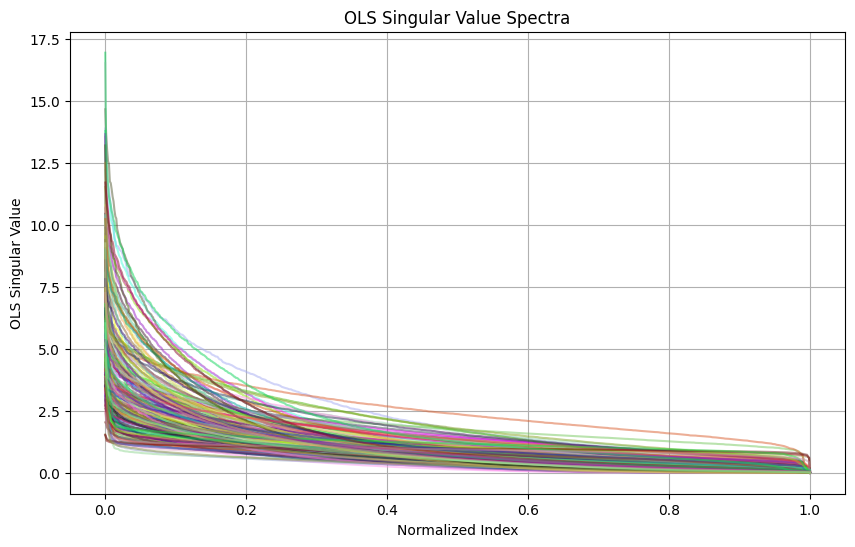

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

for sv_values, sv_coords in zip(all_singular_values_ols, all_singular_values_coordinates_ols):
    color = np.random.rand(3,) # Generate random RGB color
    plt.plot(sv_coords.numpy(), sv_values.numpy(), color=color, alpha=0.5)

plt.xlabel('Normalized Index')
plt.ylabel('OLS Singular Value')
plt.title('OLS Singular Value Spectra')
# plt.yscale('log')  # Use log scale since singular values often span orders of magnitude
plt.grid(True)
plt.show()


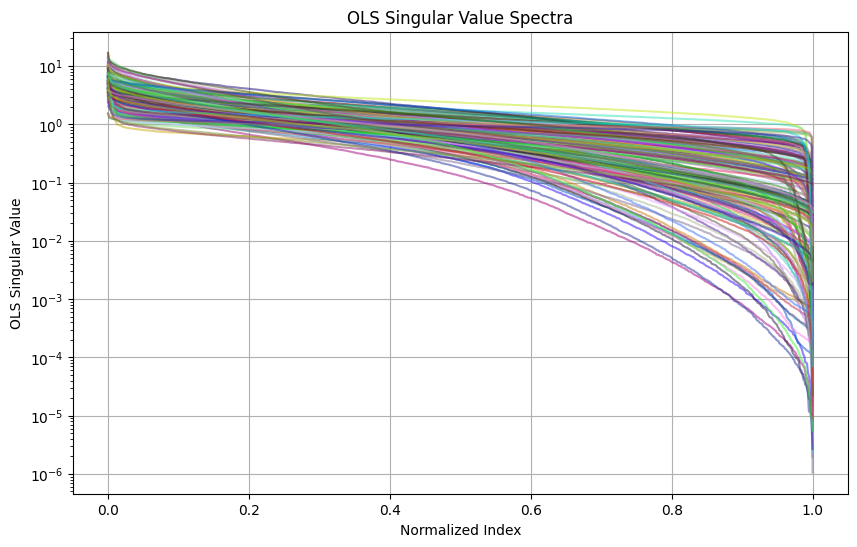

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

for sv_values, sv_coords in zip(all_singular_values_ols, all_singular_values_coordinates_ols):
    color = np.random.rand(3,) # Generate random RGB color
    plt.plot(sv_coords.numpy(), sv_values.numpy(), color=color, alpha=0.5)

plt.xlabel('Normalized Index')
plt.ylabel('OLS Singular Value')
plt.title('OLS Singular Value Spectra')
plt.yscale('log')  # Use log scale since singular values often span orders of magnitude
plt.grid(True)
plt.show()

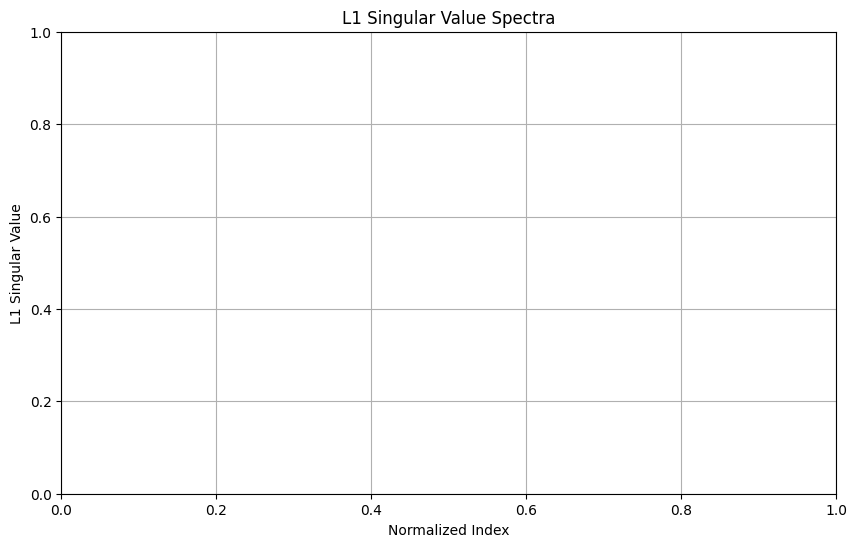

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

for sv_values, sv_coords in zip(all_singular_values_l1, all_singular_values_coordinates_l1):
    color = np.random.rand(3,) # Generate random RGB color
    plt.plot(sv_coords.numpy(), sv_values.numpy(), color=color, alpha=0.5)

plt.xlabel('Normalized Index')
plt.ylabel('L1 Singular Value')
plt.title('L1 Singular Value Spectra')
# plt.yscale('log')  # Use log scale since singular values often span orders of magnitude
plt.grid(True)
plt.show()

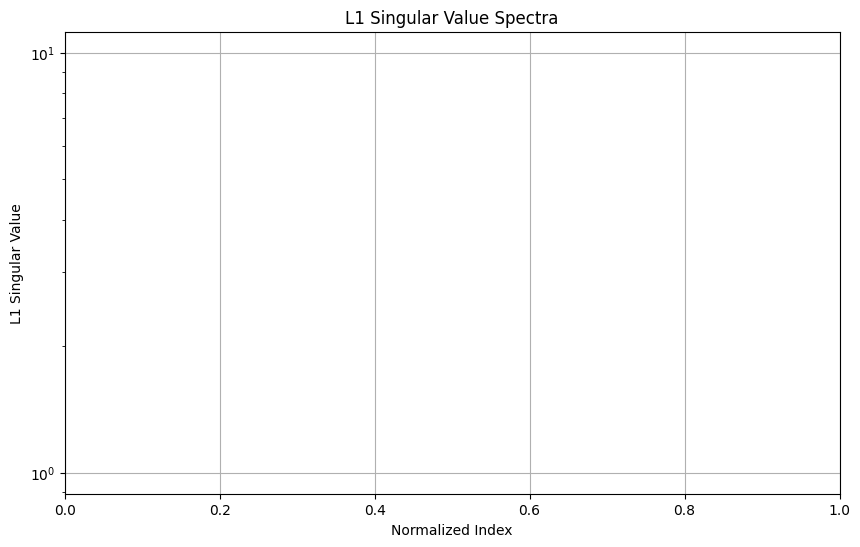

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

for sv_values, sv_coords in zip(all_singular_values_l1, all_singular_values_coordinates_l1):
    color = np.random.rand(3,) # Generate random RGB color
    plt.plot(sv_coords.numpy(), sv_values.numpy(), color=color, alpha=0.5)

plt.xlabel('Normalized Index')
plt.ylabel('L1 Singular Value')
plt.title('L1 Singular Value Spectra')
plt.yscale('log')  # Use log scale since singular values often span orders of magnitude
plt.grid(True)
plt.show()

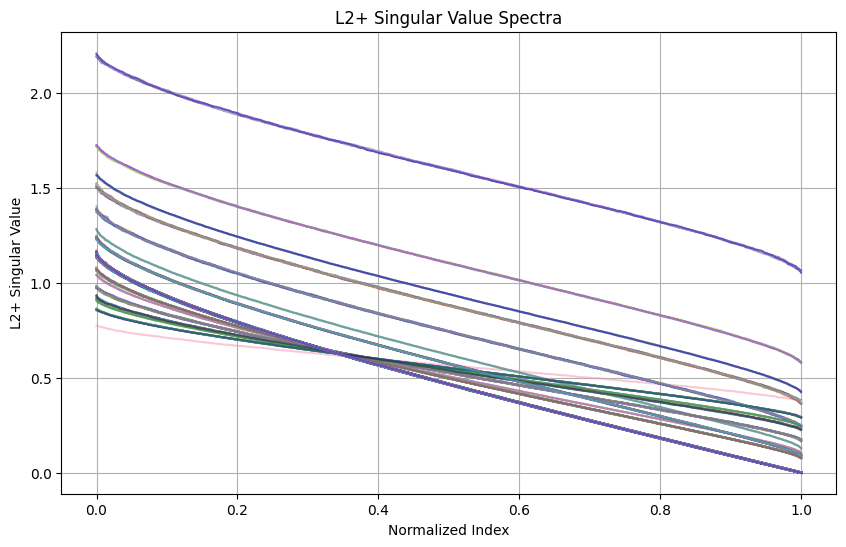

In [31]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

for sv_values, sv_coords in zip(all_singular_values_l2plus, all_singular_values_coordinates_l2plus):
    color = np.random.rand(3,) # Generate random RGB color
    plt.plot(sv_coords.numpy(), sv_values.numpy(), color=color, alpha=0.5)

plt.xlabel('Normalized Index')
plt.ylabel('L2+ Singular Value')
plt.title('L2+ Singular Value Spectra')
# plt.yscale('log')  # Use log scale since singular values often span orders of magnitude
plt.grid(True)
plt.show()

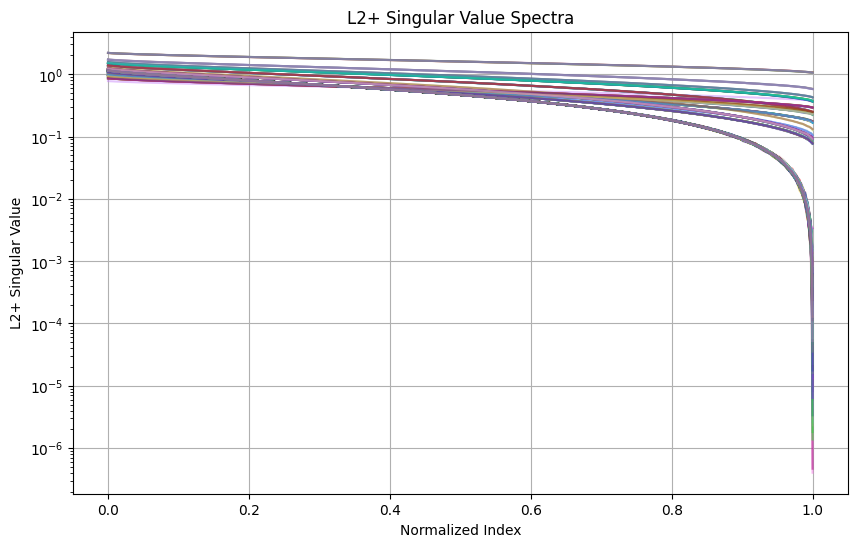

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

for sv_values, sv_coords in zip(all_singular_values_l2plus, all_singular_values_coordinates_l2plus):
    color = np.random.rand(3,) # Generate random RGB color
    plt.plot(sv_coords.numpy(), sv_values.numpy(), color=color, alpha=0.5)

plt.xlabel('Normalized Index')
plt.ylabel('L2+ Singular Value')
plt.title('L2+ Singular Value Spectra')
plt.yscale('log')  # Use log scale since singular values often span orders of magnitude
plt.grid(True)
plt.show()